In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchinfo import summary

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

5


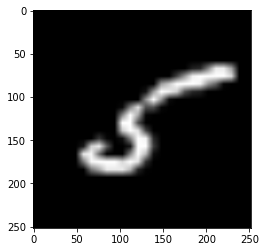

In [123]:
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
image, label = train_dataset[11]
print(label)
plt.imshow(image, cmap="gray")

a = transforms.Resize(252)(image)
plt.imshow(a, cmap="gray")

In [146]:
batch_size = 128
learning_rate = 0.001
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)])
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torchvision.

In [125]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_features)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-

In [147]:
def data_aug(img_tensor):
    aug = transforms.RandomResizedCrop(224, scale=(0.08,0.1))(img_tensor)
    aug = transforms.RandomHorizontalFlip(p=0.5)(aug)
    aug = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)(aug)
    #aug = transforms.RandomGrayscale(0.2)(aug)
    aug = transforms.GaussianBlur(kernel_size=23, sigma=0.5)(aug)
    aug = transforms.RandomSolarize(threshold=0.3,p=0.1)(aug)
    #aug = transforms.Normalize()(aug)
    return aug


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1014, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1, 1014)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [153]:
N = 64
data = torch.rand(N,1,28,28)
data = data_aug(data)
print(data.shape)
conv1 = nn.Conv2d(1, 12, kernel_size=1)
conv2 = nn.Conv2d(12, 6, kernel_size=3)
max_pool = nn.MaxPool2d(2, 2)
x = conv1(data)
print(x.shape)
x = conv2(x)
print(x.shape)
x = max_pool(x)
print(x.shape)
x = x.view(-1,73926)
fc1 = nn.Linear(73926, 256)
x = fc1(x)
print(x.shape)
fc2 = nn.Linear(256, 128)
x = fc2(x)
print(x.shape)
fc3 = nn.Linear(128,10)
x = fc3(x)
print(x.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 12, 224, 224])
torch.Size([64, 6, 222, 222])
torch.Size([64, 6, 111, 111])
torch.Size([64, 256])
torch.Size([64, 128])
torch.Size([64, 10])


In [128]:
model = CNN().to(device=device)
out = model(train_features)
print(f'Output shape of one MNIST image {out.shape}')

Output shape of one MNIST image torch.Size([64, 10])


In [149]:
epochs = 20
model = CNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # images = data_aug(images)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} ')



Epoch [1/20], Step [100/469], Loss: 0.3038 
Epoch [1/20], Step [200/469], Loss: 0.2584 
Epoch [1/20], Step [300/469], Loss: 0.1767 
Epoch [1/20], Step [400/469], Loss: 0.1617 
Epoch [2/20], Step [100/469], Loss: 0.2216 
Epoch [2/20], Step [200/469], Loss: 0.1035 
Epoch [2/20], Step [300/469], Loss: 0.0845 
Epoch [2/20], Step [400/469], Loss: 0.1242 
Epoch [3/20], Step [100/469], Loss: 0.0643 
Epoch [3/20], Step [200/469], Loss: 0.0917 
Epoch [3/20], Step [300/469], Loss: 0.0717 
Epoch [3/20], Step [400/469], Loss: 0.0790 
Epoch [4/20], Step [100/469], Loss: 0.2221 
Epoch [4/20], Step [200/469], Loss: 0.0387 
Epoch [4/20], Step [300/469], Loss: 0.0663 
Epoch [4/20], Step [400/469], Loss: 0.0246 
Epoch [5/20], Step [100/469], Loss: 0.0178 
Epoch [5/20], Step [200/469], Loss: 0.0096 


KeyboardInterrupt: 

## Testing Torch Augmentations

In [154]:
class CNN_augs(nn.Module):
    def __init__(self):
        super(CNN_augs, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(73926, 256)
        self.fc2 = nn.Linear(256, 128)
        # change output channels to multiples of 2 --> maybe 16, 32??
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1,73926)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [161]:
model = CNN_augs().to(device=device)
summary(model, input_size=[(batch_size, 1, 224, 224)])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_augs                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 12, 224, 224]       24
├─Conv2d: 1-2                            [128, 6, 222, 222]        654
├─MaxPool2d: 1-3                         [128, 6, 111, 111]        --
├─Linear: 1-4                            [128, 256]                18,925,312
├─Linear: 1-5                            [128, 128]                32,896
├─Linear: 1-6                            [128, 10]                 1,290
Total params: 18,960,176
Trainable params: 18,960,176
Non-trainable params: 0
Total mult-adds (G): 6.71
Input size (MB): 25.69
Forward/backward pass size (MB): 919.77
Params size (MB): 75.84
Estimated Total Size (MB): 1021.30

In [158]:
epochs = 20
model = CNN_augs().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = data_aug(images)
        labels = labels.to(device)

        outputs = model(images)
        # compute loss between two different data augs!
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} ')


KeyboardInterrupt: 

In [133]:
data = torch.rand(N,1,28,28)
image_sample = train_features
aug = transforms.RandomResizedCrop(224, scale=(0.08,0.1))(train_features)
print(aug.shape)

torch.Size([64, 1, 224, 224])


In [138]:
def data_aug(img_tensor):
    #change to (20, 20)
    aug = transforms.RandomResizedCrop(224, scale=(0.08,0.1))(img_tensor)
    aug = transforms.RandomHorizontalFlip(p=0.5)(aug)
    aug = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)(aug)
    #aug = transforms.RandomGrayscale(0.2)(aug)
    aug = transforms.GaussianBlur(kernel_size=23, sigma=0.5)(aug)
    aug = transforms.RandomSolarize(threshold=0.3,p=0.1)(aug)
    #aug = transforms.Normalize()(aug)
    return aug

In [139]:
transformed_image = data_aug(image_sample)
print(transformed_image.shape)

torch.Size([64, 1, 224, 224])


## Downstream tasks
- **Classification**
- Regression
- Simulate representation of the data
- Autoencoder --> anomaly detection